In [1]:
import numpy as np
import torch
import sympy
import random as rand
import matplotlib.pyplot as plt

In [2]:
def get_pi_vec(m):

    num_row = m.size()[0]
    num_col = m.size()[1]    

    temp = np.transpose(m) - np.identity(num_row)

    temp[num_row - 1,:] = 1

    zeros = np.zeros((num_row,1))
    zeros[-1] = 1

    temp = np.hstack((temp, zeros))

    M = sympy.Matrix(temp)
        
    temp = M.rref()[0]

    return temp[:, num_col]



In [3]:
# Let's define an arbritrary Markov Chain to see how to conduct the basics

m = torch.tensor([[.25, .4, .1, .25], [.2, .3, .2, .3], [.1, .3, .44, .16], [.1, .23, .37, .3]])

print(m)

tensor([[0.2500, 0.4000, 0.1000, 0.2500],
        [0.2000, 0.3000, 0.2000, 0.3000],
        [0.1000, 0.3000, 0.4400, 0.1600],
        [0.1000, 0.2300, 0.3700, 0.3000]])


In [4]:
temp = m

for i in range(100):
    temp = torch.matmul(temp,m)

print(temp)

tensor([[0.1527, 0.2977, 0.2991, 0.2505],
        [0.1527, 0.2977, 0.2991, 0.2505],
        [0.1527, 0.2977, 0.2991, 0.2505],
        [0.1527, 0.2977, 0.2991, 0.2505]])


In [5]:
pi_vec = get_pi_vec(m)

In [6]:
pi_vec[:]

[0.152674472695713, 0.297733000850855, 0.299100305186729, 0.250492221266704]

Now that we have set up our machinery, its time to look into how we can leverge it to track sequences of numbes and generate trends

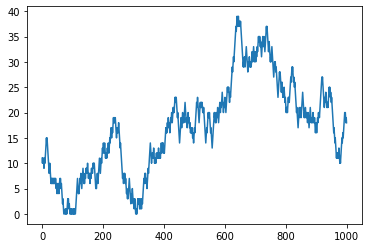

In [7]:
# Set up random number sequences

x_points = []
y_points = []

price = 10

for i in range(1000):
    x_points.append(i)

    if rand.randrange(0, 2) == 0:
        if price != 0:
            y_points.append(price - 1)
            price -= 1
        else:
            y_points.append(price)
    else:
        y_points.append(price + 1)
        price += 1

plt.plot(x_points, y_points)

In [40]:
# Let's create a new Markov Chain for identifying trends

# Markov Chain Layout:
# 
#          Up    Down 
#  Up   |             
#  Down |            

gator = np.array([[0.0,0.0],[0.0,0.0]])

prev_price = 0
prev_state = -1
curr_state = -1

for i in range(100, 200):

    # Use the first state to initialze the Markov Chain
    if i == 0:
        prev_price = y_points[i]
        continue

    if prev_price < y_points[i]:
        curr_state = 1

        if prev_state != -1 and curr_state != -1:
            gator[prev_state, curr_state] += 1

        prev_state = curr_state

    else:
        curr_state = 0

        if prev_state != -1 and curr_state != -1:
            gator[prev_state, curr_state] += 1

        prev_state = curr_state

gator

array([[ 3.,  4.],
       [ 3., 89.]])

In [41]:
num_row = gator.shape[0]
num_col = gator.shape[1]

In [42]:
for i in range(num_row):
    gator[i] = np.array([value / float(sum(gator[i])) for value in gator[i]])

In [43]:
gator

array([[0.42857143, 0.57142857],
       [0.0326087 , 0.9673913 ]])

In [44]:
gator_pi = get_pi_vec(torch.from_numpy(gator))

In [45]:
gator_pi[:]

[0.0539845758354756, 0.946015424164524]

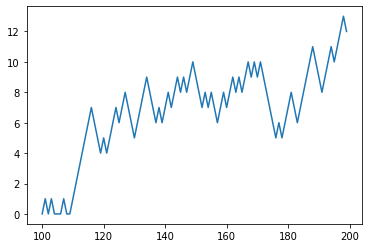

In [46]:
plt.plot(x_points[100:200], y_points[100:200])

In [69]:
from yahoofinancials import YahooFinancials

yf = YahooFinancials('AAPL')

hist_data = yf.get_historical_price_data('2020-01-01', '2024-01-01', 'daily')

In [70]:
day = []
stock_prices = []

for i, price in enumerate(hist_data['AAPL']['prices']):
    stock_prices.append(price['open'])
    day.append(i)

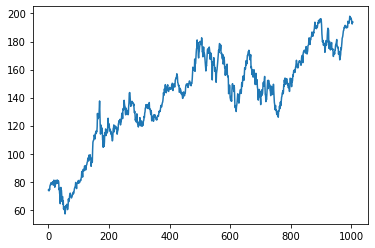

In [71]:
plt.plot(day, stock_prices)

In [89]:
# Let's create a new Markov Chain for identifying trends

# Markov Chain Layout:
# 
#          Up    Down 
#  Up   |             
#  Down |            

gator = np.array([[0.0,0.0],[0.0,0.0]])

prev_price = 0
prev_state = -1
curr_state = -1

for i in range(0, 200):

    # Use the first state to initialze the Markov Chain
    if i == 0:
        prev_price = stock_prices[i]
        continue

    if prev_price < stock_prices[i]:
        curr_state = 1

        if prev_state != -1 and curr_state != -1:
            gator[prev_state, curr_state] += 1

        prev_state = curr_state

    else:
        curr_state = 0

        if prev_state != -1 and curr_state != -1:
            gator[prev_state, curr_state] += 1

        prev_state = curr_state

gator

array([[ 45.,   3.],
       [  3., 147.]])

In [90]:
num_row = gator.shape[0]
num_col = gator.shape[1]

In [91]:
for i in range(num_row):
    gator[i] = np.array([value / float(sum(gator[i])) for value in gator[i]])

In [92]:
gator_pi = get_pi_vec(torch.from_numpy(gator))

gator_pi[:]

[0.242424242424242, 0.757575757575758]

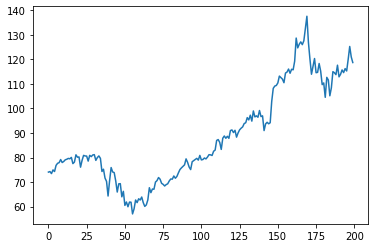

In [93]:
plt.plot(day[0:200], stock_prices[0:200])